In [12]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import joblib
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import cross_val_score, HalvingGridSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.patches as patches  # extra code – for the curved arrow
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, recall_score
import lightgbm as lgb
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import make_column_selector, make_column_transformer
warnings.filterwarnings('ignore')

In [13]:
%matplotlib inline

In [14]:
def pandas_preprocessing(X, y_present=True):
  X['PassengerId_split'] = X['PassengerId'].apply(lambda x : str(x).split(sep = '_', maxsplit=1))
  X['Group']= X['PassengerId_split'].apply(lambda x : np.nan if x[0] == 'nan' else x[0])
  X['Group_id']= X['PassengerId_split'].apply(lambda x : np.nan if x[0] == 'nan' else x[1])
  X = X.drop(['PassengerId','PassengerId_split'],axis=1)

  # Split the names
  X['Name_split'] = X['Name'].apply(lambda x : str(x).split(sep = ' ', maxsplit=1))
  X['Surname']= X['Name_split'].apply(lambda x : np.nan if x[0] == 'nan' else x[1])
  X = X.drop(['Name','Name_split'],axis=1)

  # Split the cabins
  X['Cabin_splt'] = X['Cabin'].apply(lambda x : str(x).split(sep = '/'))
  X['Deck']= X['Cabin_splt'].apply(lambda x : np.nan if x[0] == 'nan' else x[0])
  X['CabinNumber']= X['Cabin_splt'].apply(lambda x : np.nan if x[0] == 'nan' else x[1]).astype('float')
  X['CabinSide']= X['Cabin_splt'].apply(lambda x : np.nan if x[0] == 'nan' else x[2])
  X = X.drop(['Cabin','Cabin_splt'],axis=1)

  # Create Total
  numeric_cols = list(X.select_dtypes(include = np.number).columns)
  X['Total'] = sum(X[col] for col in numeric_cols if col not in ["Age", "CabinNumber"])
  # X['age'] = pd.cut(x=X['Age'], bins=range(0, 90, 10))
  # X['total'] = pd.cut(x=X['Total'], bins=[-35.987, 3598.7, 7197.4, 10796.1, 14394.8, 17993.5, 21592.2, 25190.9, 28789.6, 32388.3, 35987.])
  # X = X.drop(['Age', "Total"],axis=1)
  # X['age'] = X['age'].astype('str') 
  # X['total'] = X['total'].astype('str')
  target = X['Transported']
  target = target.astype(int)
  X = X.drop(['Transported'],axis=1)
  return X, target

In [15]:
bol_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    )

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    )


num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

preprocessing_pipe = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
    (bol_pipeline, make_column_selector(dtype_include=bool)),
)

In [16]:
df = pd.read_csv('data_FAA/train.csv')
df, y = pandas_preprocessing(df)
df_prepared = preprocessing_pipe.fit_transform(df)

In [17]:
df_prepared_fr = pd.DataFrame(
    df_prepared,
    columns=preprocessing_pipe.get_feature_names_out(),
    index=df.index)
df_prepared_fr.head()
X_train, X_test, y_train, y_test = train_test_split(df_prepared_fr, y, test_size = 0.2, random_state = 100)

In [20]:
if redo_grid_search:
  PARAMETERS = {'booster' : ['gbtree', "dart"],
                'gamma': [1, 5,],
                'eta': [0.05],
                'learning_rate': [0.05,0.1],
                "subsample": [1], 
                'max_depth': [8, 10],
                'n_estimators': [600, 1000],
                "colsample_bytree": [0.5,0.88],
                "scale_pos_weight": [1,],
                'reg_alpha': [0,1],
                'reg_lambda': [2,],}

  # HalvingGridSearchCV
  grid_search_xgb = HalvingGridSearchCV(estimator=lgb.LGBMClassifer(),param_grid=PARAMETERS,verbose = 1,
                                                            cv = 10,scoring='accuracy',max_resources=1000,random_state = 0,
                                                            resource='n_samples',n_jobs=-1).fit(X_train.values, y_train.values.ravel())

  lbg_best = grid_search_xgb.best_estimator_
  print("LGBM Classifer")
  print('LGBM Classifer Best Score',grid_search_xgb.best_score_)
  print('LGBM Classifer Best Parmas',grid_search_xgb.best_params_)
  print('LGBM Classifer Accuracy',cross_val_score(lbg_best,X_train.values, y_train.values.ravel(), cv=10).mean())
else:
  xbg_best = xgb.XGBClassifier(booster='dart', colsample_bytree=0.88, gamma=5, learning_rate=0.1)

In [21]:
y_pred = cross_val_predict(xbg_best, X_train, y_train, cv=20)

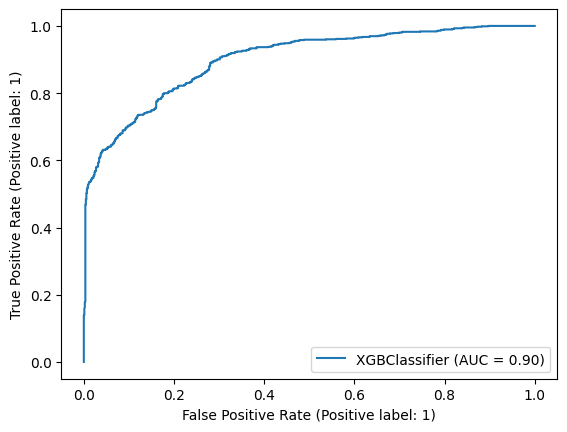

In [22]:
from sklearn.metrics import RocCurveDisplay
xbg_best.fit(X_train, y_train)
RocCurveDisplay.from_estimator(
   xbg_best, X_test, y_test)


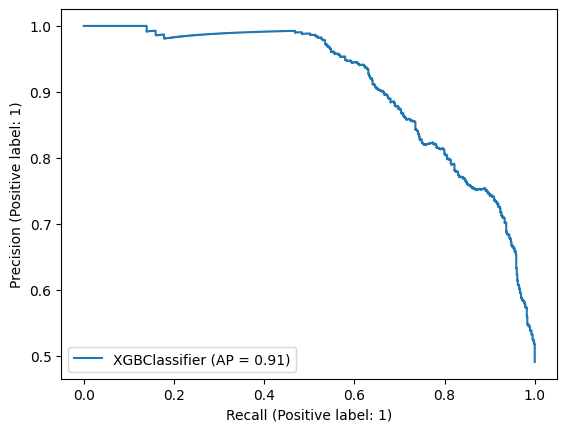

In [23]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(
   xbg_best, X_test, y_test)

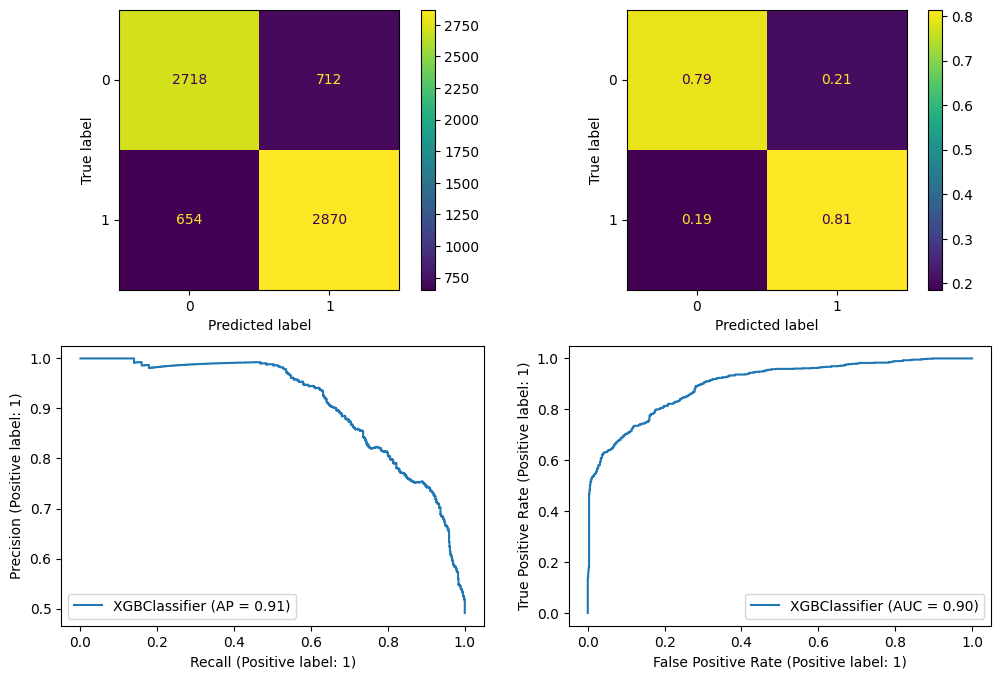

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
RocCurveDisplay.from_estimator(
   xbg_best, X_test, y_test, ax=ax[1, 1])


PrecisionRecallDisplay.from_estimator(
   xbg_best, X_test, y_test, ax=ax[1, 0])

ConfusionMatrixDisplay.from_predictions(y_train, y_pred, ax=ax[0, 0])
ConfusionMatrixDisplay.from_predictions(y_train, y_pred, normalize="true", ax=ax[0, 1])
plt.show()

In [25]:
%%time

# always use same RANDOM_STATE k-folds for comparability between tests, reproducibility
RANDOMSTATE = 42
np.random.seed(RANDOMSTATE)

kfolds = KFold(n_splits=20, shuffle=True, random_state=RANDOMSTATE)

MEAN_RESPONSE=y_train.mean()
def cv_to_raw(cv_val, mean_response=MEAN_RESPONSE):
    return np.expm1(mean_response+cv_val) - np.expm1(mean_response)
	
scores = -cross_val_score(xbg_best, X_train, y_train,
                          scoring="neg_root_mean_squared_error",
                          cv=kfolds,
                          n_jobs=-1)
raw_scores = [cv_to_raw(x) for x in scores]
print("Raw CV RMSE %.0f (STD %.0f)" % (np.mean(raw_scores), np.std(raw_scores)))

Raw CV RMSE 1 (STD 0)
CPU times: user 150 ms, sys: 154 ms, total: 304 ms
Wall time: 16.2 s


In [26]:
max_scores = sum(score for score, name in zip(xbg_best.feature_importances_, X_train.columns))

for score, name in zip(xbg_best.feature_importances_, X_train.columns):
    print(f"{score/max_scores * 100:.1f}% {' ':>20}{name.split('__', 1)[1]:>20}")

1.9%                                      Age
6.5%                              RoomService
3.3%                                FoodCourt
2.5%                             ShoppingMall
4.1%                                      Spa
5.2%                                   VRDeck
2.1%                              CabinNumber
5.0%                                    Total
8.2%                               HomePlanet
50.6%                                CryoSleep
1.5%                              Destination
0.0%                                      VIP
1.7%                                    Group
1.0%                                 Group_id
1.1%                                  Surname
2.8%                                     Deck
2.4%                                CabinSide


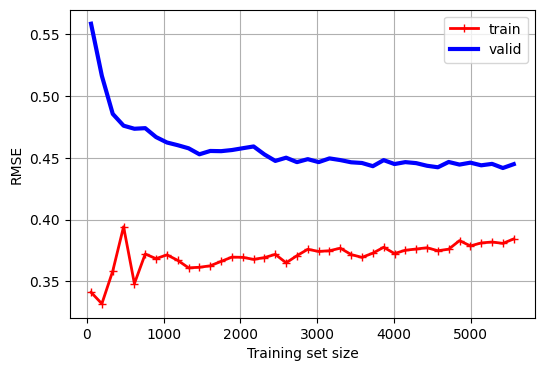

In [27]:
train_sizes, train_scores, valid_scores = learning_curve(
    xbg_best, X_train, y_train, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

# extra code – beautifies and saves Figure 4–15
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
# plt.axis([0, 1000, 0.3, 0.9])
# plt.save_fig("underfitting_learning_curves_plot")

plt.show()

In [28]:
#----------------For submission----------------
data1= pd.read_csv("data_FAA/train.csv")
data2 = pd.read_csv("data_FAA/evaluation.csv")
data2 = pd.read_csv("data_FAA/evaluation.csv")
data2['Transported'] =-1

data1, y1 = pandas_preprocessing(data1)
data2, y2 = pandas_preprocessing(data2)

data1 = preprocessing_pipe.fit_transform(data1)
data2 = preprocessing_pipe.transform(data2)

xbg_best.fit(data1, y1)

pred = xbg_best.predict(data2)

pred = pred.astype(bool)
result=pd.read_csv('data_FAA/sample_submission.csv')
result['Transported'] = pred
result.to_csv('submission_xgb.csv', index=False)